In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
import numpy as np
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
import numpy as np 
import pandas as pd 

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Training data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')


In [ ]:
df_train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
df_test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [ ]:
print(df_train.shape,df_test.shape)

(27481, 4) (3534, 3)


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [ ]:
df_train.isnull().sum()


textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [ ]:
null_columns=df_train.columns[df_train.isnull().any()]
# print all rows with atleast one null values
print(df_train[df_train.isnull().any(axis=1)][null_columns])

    text selected_text
314  NaN           NaN


In [ ]:
df_train.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)


In [ ]:
df_test.isna().sum()

textID       0
text         0
sentiment    0
dtype: int64

In [ ]:
# Contains positive tweets 
# Here we have a glimpse of positive cases
df_pos = df_train[df_train['sentiment']=='positive']
df_pos['text'].head()

6     2am feedings for the baby are fun when he is a...
9      Journey!? Wow... u just became cooler.  hehe....
11    I really really like the song Love Story by Ta...
21    Playing Ghost Online is really interesting. Th...
25    the free fillin` app on my ipod is fun, im add...
Name: text, dtype: object

In [ ]:
df_neg = df_train[df_train['sentiment']=='negative']
df_neg['text'].head()

1         Sooo SAD I will miss you here in San Diego!!!
2                             my boss is bullying me...
3                        what interview! leave me alone
4      Sons of ****, why couldn`t they put them on t...
12         My Sharpie is running DANGERously low on ink
Name: text, dtype: object

In [ ]:
df_neu = df_train[df_train['sentiment']=='neutral']
df_neu['text'].head()

0                   I`d have responded, if I were going
5     http://www.dothebouncy.com/smf - some shameles...
7                                            Soooo high
8                                           Both of you
10     as much as i love to be hopeful, i reckon the...
Name: text, dtype: object

# Data distribution based on Sentiment Column

In [ ]:
df_train['sentiment'].value_counts()


neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

So the dataset which we have got is uneven with more more neutral text than positive and negative.

<Axes: >

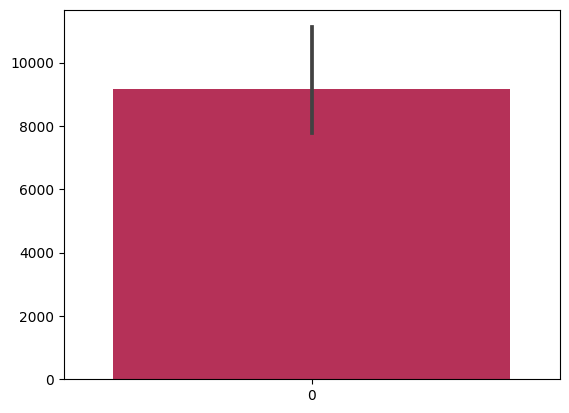

In [ ]:
sns.barplot(df_train['sentiment'].value_counts(),
            palette='rocket')

In [ ]:
df_test['sentiment'].value_counts()

neutral     1430
positive    1103
negative    1001
Name: sentiment, dtype: int64

<Axes: >

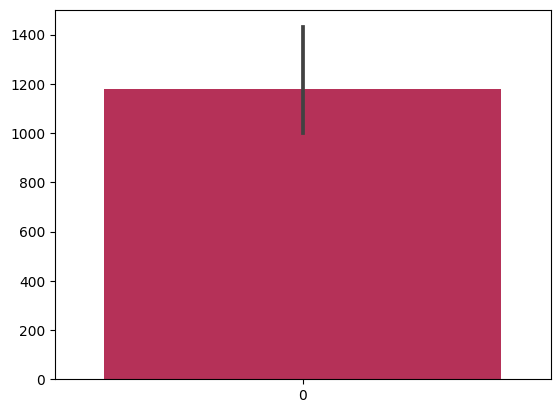

In [ ]:
sns.barplot(df_test['sentiment'].value_counts(),palette='rocket')

In [ ]:
import torch

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 20.7 MB/s eta 0:00:00


In [ ]:
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

## Demo shot : Just in case for understanding

In [ ]:
def answer_question(question, answer_text):

    # ======== Tokenize ========
    input_ids = tokenizer.encode(question, answer_text)

    # Report how long the input sequence is.
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # Segment A token frequency.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    # ======== Evaluate ========
    start_scores, end_scores = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]),return_dict=False) 
  
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]

        else:
            answer += ' ' + tokens[i]

    return answer

In [ ]:
text ='Spent the entire morning in a meeting w/ a vendor, and my boss was not happy w/ them. Lots of fun.I had other plans for my morning'
question = 'What text is negative?'

In [ ]:
ans = answer_question(question, text)
print(ans)

my boss was not happy w / them


In [ ]:
# Initialise the text
df_train['Bert_answers'] = ''

In [ ]:
df_train.head()

,textID,text,selected_text,sentiment,Bert_answers
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,
2,088c60f138,my boss is bullying me...,bullying me,negative,
3,9642c003ef,what interview! leave me alone,leave me alone,negative,
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,


### Three questions are asked to BERT



In [ ]:
positive_question = 'What text is positive ?' # In case of positive sentiment
negative_question = 'What text is negative ?'  # In case of negative sentiment
neutral_question = 'What text is neutral?' # In case of neutral sentiment

In [ ]:
df_test.shape[0]

3534

In [ ]:

df_test['selected_text'] = ''
i = 0
while(i!=df_test.shape[0]):
    if (df_test['sentiment'].iloc[i]== 'positive'):
        df_test['selected_text'].iloc[i] = answer_question(positive_question,df_test['text'][i])
    elif (df_test['sentiment'].iloc[i]== 'negative'):
        df_test['selected_text'].iloc[i] = answer_question(negative_question,df_test['text'][i])
    else :
        df_test['selected_text'].iloc[i] = answer_question(neutral_question,df_test['text'][i])
    print(df_test['selected_text'].iloc[i])
    print(i)
    i = i+1
    
     


Streaming output truncated to the last 5000 lines.
crying
1034
what text is neutral ? [SEP]
1035
happy star wars day
1036
video
1037
it ` s mother ` s day
1038
yay for birthdays
1039
what text is positive ? [SEP]
1040
jonas brothers day
1041
what text is negative ? [SEP] i ` m at work . . . . bored out of my mind .
1042
watching the notebook
1043
ixigo . com
1044
twitterific ? twitdroid ? twitterberry
1045
sleep time
1046
4l85a
1047
what text is negative ? [SEP]
1048
what text is negative ? [SEP]
1049
kanji
1050
britains got talent
1051
i love mi madre
1052
what text is negative ? [SEP] they wouldn ` t reverse any of my overdraft fees .
1053
i ` m not having a good day
1054
soulja boy dance
1055
i need 2 drop some friends . dammit !
1056
essays
1057
lo
1058
home , good night world
1059
she is really cute
1060
so glad i got this job ! !
1061
lappy charger is completely dead . . . conserving what ` s left of the battery
1062
no chillin and concert with me huh
1063
happy mother ` s day
10

In [ ]:
df_test.head()

,textID,text,sentiment,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,last session of the day http : / / twitpic . c...
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,( sh ) ( bj )
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,recession
3,01082688c6,happy bday!,positive,happy bday !
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,4w75p


In [ ]:
df_test2 = df_test
df_test2

,textID,text,sentiment,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,last session of the day http : / / twitpic . c...
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,( sh ) ( bj )
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,recession
3,01082688c6,happy bday!,positive,happy bday !
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,4w75p
...,...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative,im
3530,416863ce47,All alone in this old house again. Thanks for...,positive,thanks for the net which keeps me alive and ki...
3531,6332da480c,I know what you mean. My little dog is sinkin...,negative,my little dog is sinking into depression
3532,df1baec676,_sutra what is your next youtube video gonna b...,positive,_ sutra what is your next youtube


In [ ]:
df_test = df_test.drop(['text','sentiment'],axis = 1)
df_test.head()

,textID,selected_text
0,f87dea47db,last session of the day http : / / twitpic . c...
1,96d74cb729,( sh ) ( bj )
2,eee518ae67,recession
3,01082688c6,happy bday !
4,33987a8ee5,4w75p


In [ ]:
def jaccard(str1, str2): 
    a = set(str(str1).lower().split()) 
    b = set(str(str2).lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))
def plot_jaccard(sentiment,ax):
    jacc=[]
    text=df_test2[df_test2['sentiment']==sentiment].dropna()['text'].values.tolist()
    selected=df_test2[df_test2['sentiment']==sentiment].dropna()['selected_text'].values.tolist()
    for i,k in zip(text,selected):
        jacc.append(jaccard(i,k))
    ax.hist(jacc,bins=10,color='blue',alpha=0.4)
    ax.set_title(sentiment)

Text(0.5, 0.98, 'jaccard similarity of text and selected text')

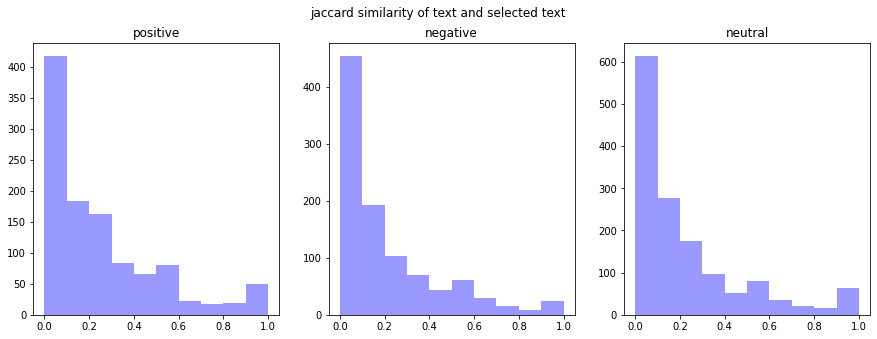

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
plot_jaccard('positive',ax=ax1)
plot_jaccard('negative',ax2)
plot_jaccard('neutral',ax3)
fig.suptitle('jaccard similarity of text and selected text')

In [ ]:
df_test.set_index('textID',inplace = True)
df_test.head()

,selected_text
textID,
f87dea47db,last session of the day http : / / twitpic . c...
96d74cb729,( sh ) ( bj )
eee518ae67,recession
01082688c6,happy bday !
33987a8ee5,4w75p
